## Importing important libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve,f1_score,auc
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")
import joblib

In [2]:
df=pd.read_csv('data_interview_test.csv',delimiter=':')

## Univariate analysis (Checking missing values, outliers, distribution, mean)

In [3]:
df.dtypes

receipt_id                  object
company_id                   int64
matched_transaction_id      object
feature_transaction_id      object
DateMappingMatch           float64
AmountMappingMatch         float64
DescriptionMatch           float64
DifferentPredictedTime     float64
TimeMappingMatch           float64
PredictedNameMatch         float64
ShortNameMatch             float64
DifferentPredictedDate     float64
PredictedAmountMatch       float64
PredictedTimeCloseMatch    float64
dtype: object

In [4]:
match_cols=['DateMappingMatch',
'AmountMappingMatch',
'DescriptionMatch',
'DifferentPredictedTime',
'TimeMappingMatch',
'PredictedNameMatch',
'ShortNameMatch',
'DifferentPredictedDate',
'PredictedAmountMatch',
'PredictedTimeCloseMatch']

In [5]:
df[match_cols].describe(percentiles=[0,0.1,0.7,0.9,0.99]).T

,count,mean,std,min,0%,10%,50%,70%,90%,99%,max
DateMappingMatch,12034.0,0.217901,0.384535,0.0,0.0,0.0,0.0,0.0,0.95,0.95,1.0
AmountMappingMatch,12034.0,0.031660,0.122611,0.0,0.0,0.0,0.0,0.0,0.00,0.70,0.9
DescriptionMatch,12034.0,0.021522,0.116995,0.0,0.0,0.0,0.0,0.0,0.00,0.80,0.8
DifferentPredictedTime,12034.0,0.986455,0.115597,0.0,0.0,1.0,1.0,1.0,1.00,1.00,1.0
TimeMappingMatch,12034.0,0.013877,0.116987,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1.0
PredictedNameMatch,12034.0,0.024215,0.128646,0.0,0.0,0.0,0.0,0.0,0.00,0.80,0.8
ShortNameMatch,12034.0,0.037893,0.190945,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1.0
DifferentPredictedDate,12034.0,0.753532,0.430972,0.0,0.0,0.0,1.0,1.0,1.00,1.00,1.0
PredictedAmountMatch,12034.0,0.001005,0.020134,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.6
PredictedTimeCloseMatch,12034.0,0.076533,0.265860,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1.0


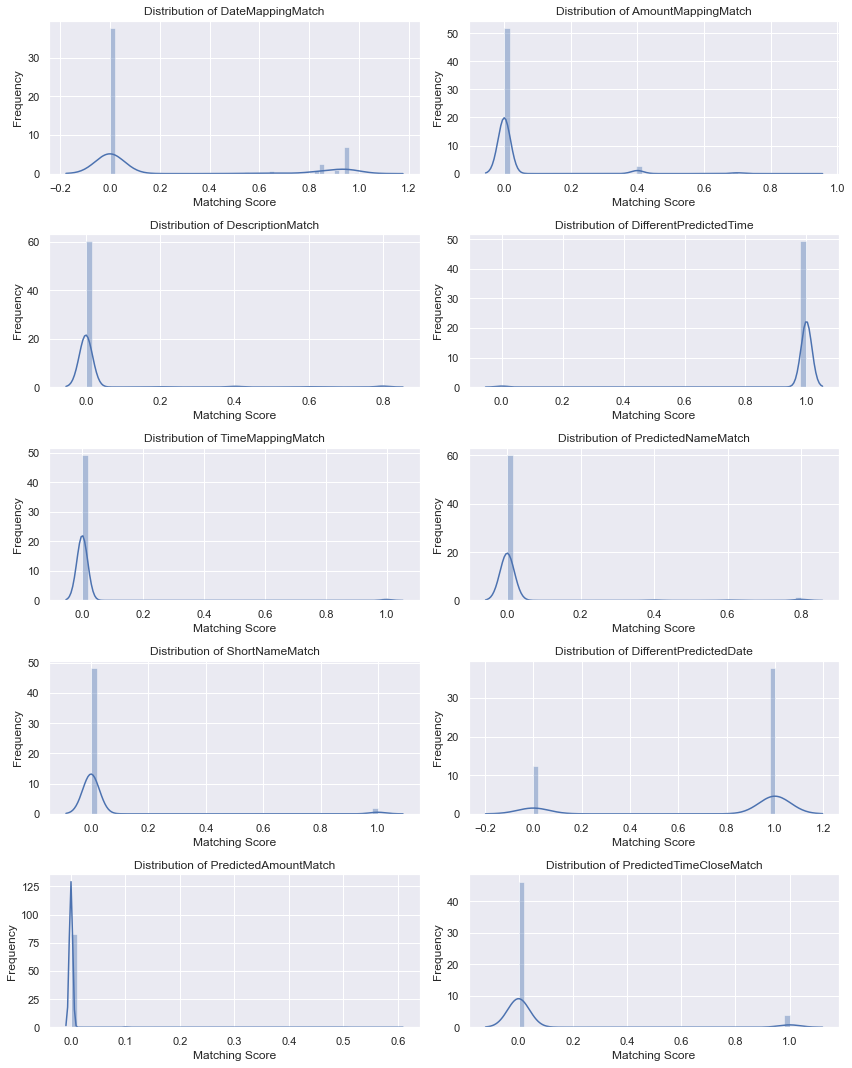

In [6]:
sns.set(rc={'figure.figsize':(12,15)})
for i, column in enumerate(match_cols, 1):
    plt.subplot(5,2,i)    
    sns.distplot(df[column])
    plt.xlabel('Matching Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# Insights

1. No outliers found observing the max value
2. No missing values found observing at the count
3. Range for matching properties data seem to be [0,1]


### Identifying correctly tagged transaction to train the model

In [7]:
df['correct_classification_flag']=df.apply(lambda x: 1 if x.matched_transaction_id==x.feature_transaction_id else 0,axis=1)

### Identifying receipts which have altest 1 correctly tagged transaction

In [8]:
df['match_available'] = df.groupby('receipt_id')['correct_classification_flag'].transform('max')

In [9]:
print('Total unique receipts: ',df.receipt_id.nunique())
print('Receipts with atleast 1 correctly tagged transaction',df[df.match_available==1].receipt_id.nunique())


Total unique receipts:  1155
Receipts with atleast 1 correctly tagged transaction 857


## Bivariate Analysis

In [10]:
X_Y_cols=match_cols+['correct_classification_flag']

In [11]:
df[match_cols+['correct_classification_flag']].corr()

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,correct_classification_flag
DateMappingMatch,1.000000,-0.008016,0.148044,-0.189589,0.190991,0.181834,0.196076,-0.990860,0.020592,0.155376,0.495295
AmountMappingMatch,-0.008016,1.000000,-0.014947,-0.008440,0.007606,-0.031537,0.026491,0.010701,0.287053,0.016421,0.009137
DescriptionMatch,0.148044,-0.014947,1.000000,-0.086593,0.093542,0.265744,0.104109,-0.147950,0.002102,0.078492,0.305888
DifferentPredictedTime,-0.189589,-0.008440,-0.086593,1.000000,-0.987785,-0.127711,-0.161234,0.181536,0.005852,-0.407039,-0.370068
TimeMappingMatch,0.190991,0.007606,0.093542,-0.987785,1.000000,0.125658,0.162474,-0.182699,-0.005925,0.401384,0.373170
PredictedNameMatch,0.181834,-0.031537,0.265744,-0.127711,0.125658,1.000000,0.395011,-0.173544,-0.008117,0.077021,0.295999
ShortNameMatch,0.196076,0.026491,0.104109,-0.161234,0.162474,0.395011,1.000000,-0.186434,0.018191,0.068922,0.324105
DifferentPredictedDate,-0.990860,0.010701,-0.147950,0.181536,-0.182699,-0.173544,-0.186434,1.000000,-0.018367,-0.150141,-0.475173
PredictedAmountMatch,0.020592,0.287053,0.002102,0.005852,-0.005925,-0.008117,0.018191,-0.018367,1.000000,0.035304,0.077648
PredictedTimeCloseMatch,0.155376,0.016421,0.078492,-0.407039,0.401384,0.077021,0.068922,-0.150141,0.035304,1.000000,0.216837


### Correlation Analysis [Checking Multicollinearity and identifying important features]

<AxesSubplot:>

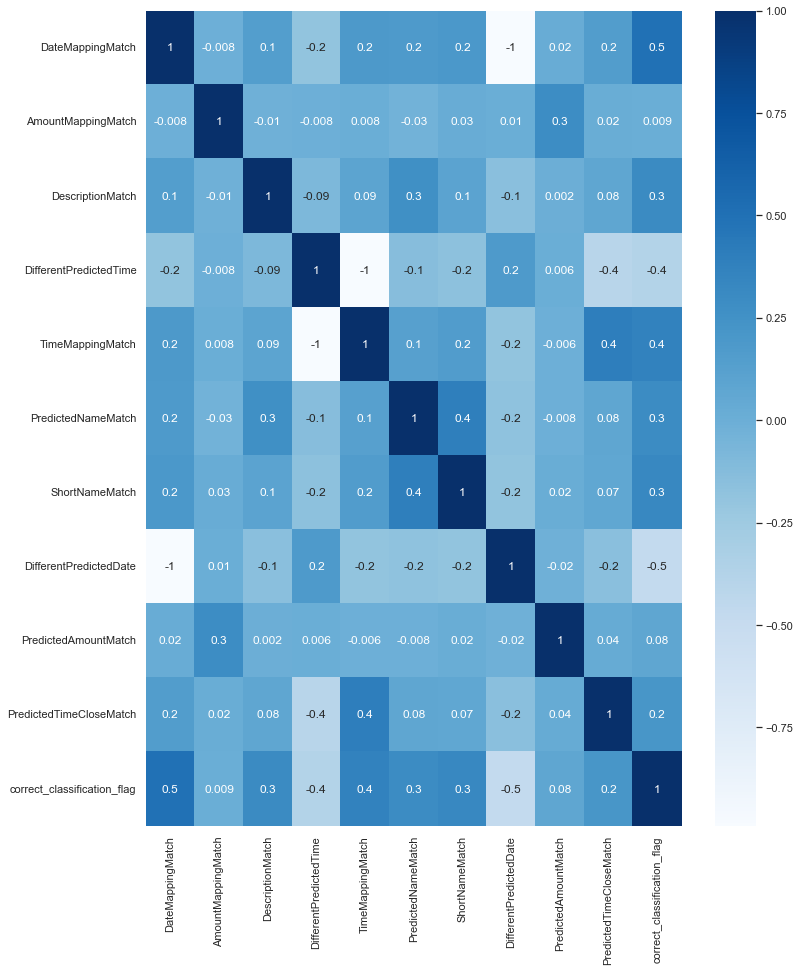

In [12]:
sns.heatmap(df[match_cols+['correct_classification_flag']].corr(), annot=True, cmap="Blues", fmt='.1g')

# Bivariate analysis 

1. DifferntPredictedDate and DateMappingMatch are perfectly correlated
2. DifferentPredictedTime and TimeMappingMatch are perfectly correlated.
3. DateMappingMatch has the highest correlation with the correct transaction tagging classification followed by TimeMappingMatch
4. Name and descriptions mapping have shown a positive correlation with correct classification


For preventing duplicate variables in the model, we can skip one of them, we can keep DateMappingMatch and TimeMappingMatch





In [16]:
match_cols=['DateMappingMatch',
'AmountMappingMatch',
'DescriptionMatch',
'TimeMappingMatch',
'PredictedNameMatch',
'ShortNameMatch',
'PredictedAmountMatch',
'PredictedTimeCloseMatch']

### Training data

In [17]:
X = df[match_cols]  # Features
y = df['correct_classification_flag']  # Target variable

df['match_available'] = df.groupby('receipt_id')['correct_classification_flag'].transform('max')
print(df.shape)


(12034, 16)


### Training the model

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87,shuffle=True)

lgb_model = lgb.LGBMClassifier(num_iterations=300,learning_rate=0.1,max_depth=8,class_weight={0:1,1:2},colsample_bytree=0.5)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

print('Training data Metrics')
accuracy = accuracy_score(y_train, lgb_model.predict(X_train))
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_train, lgb_model.predict(X_train)))

print('Testing data Metrics')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Training data Metrics
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7809
           1       0.81      0.64      0.72       614

    accuracy                           0.96      8423
   macro avg       0.89      0.82      0.85      8423
weighted avg       0.96      0.96      0.96      8423

Testing data Metrics
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3368
           1       0.77      0.60      0.67       243

    accuracy                           0.96      3611
   macro avg       0.87      0.79      0.83      3611
weighted avg       0.96      0.96      0.96      3611



### Changing cutoff threshold for classifify correctly tagged transactions [Refer to plot]

In [42]:
cutoff=0.76
#Training data

y_pred_prob=lgb_model.predict_proba(X_train)[:,1]
y_pred_threshold=[ 1 if x>=cutoff else 0 for x in y_pred_prob]
print(classification_report(y_train, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7809
           1       0.89      0.57      0.70       614

    accuracy                           0.96      8423
   macro avg       0.93      0.78      0.84      8423
weighted avg       0.96      0.96      0.96      8423



In [43]:

#Testing data

y_pred_prob=lgb_model.predict_proba(X_test)[:,1]
y_pred_threshold=[ 1 if x>=cutoff else 0 for x in y_pred_prob]
print(classification_report(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3368
           1       0.88      0.56      0.69       243

    accuracy                           0.97      3611
   macro avg       0.93      0.78      0.84      3611
weighted avg       0.96      0.97      0.96      3611



## Feature Importance - Frequency and Gain basis

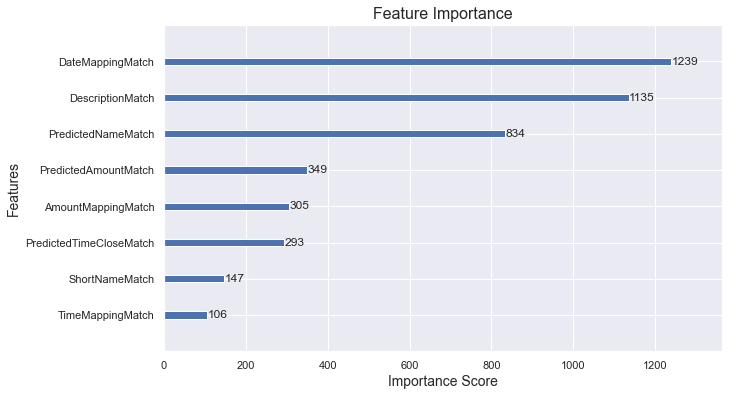

In [44]:
# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=10, figsize=(10, 6),importance_type='split')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

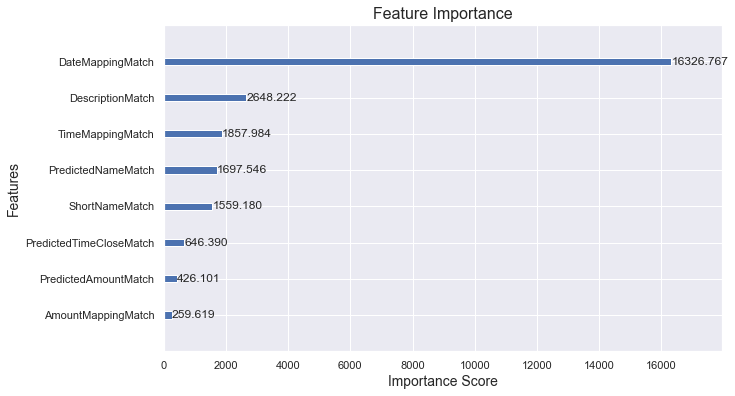

In [45]:
# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=10, figsize=(10, 6),importance_type='gain')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

## Precision Recall curve -- Training and Testing data

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7809
           1       0.89      0.57      0.70       614

    accuracy                           0.96      8423
   macro avg       0.93      0.78      0.84      8423
weighted avg       0.96      0.96      0.96      8423

LightGBM: f1=0.699 auc=0.792


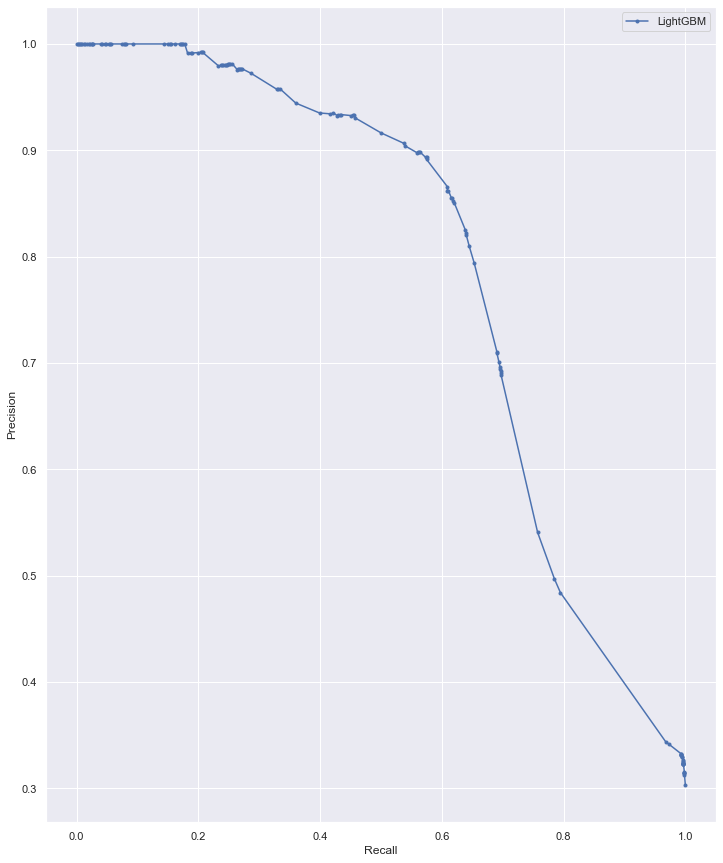

In [57]:
y_pred_prob=lgb_model.predict_proba(X_train)[:,1]
y_pred_threshold=[ 1 if x>=cutoff else 0 for x in y_pred_prob]
print(classification_report(y_train, y_pred_threshold))


lr_precision, lr_recall, _ = precision_recall_curve(y_train, y_pred_prob)
lr_f1, lr_auc = f1_score(y_train, y_pred_threshold), auc(lr_recall, lr_precision)
print('LightGBM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
pyplot.plot(lr_recall, lr_precision, marker='.', label='LightGBM')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3368
           1       0.88      0.56      0.69       243

    accuracy                           0.97      3611
   macro avg       0.93      0.78      0.84      3611
weighted avg       0.96      0.97      0.96      3611

LightGBM: f1=0.688 auc=0.749


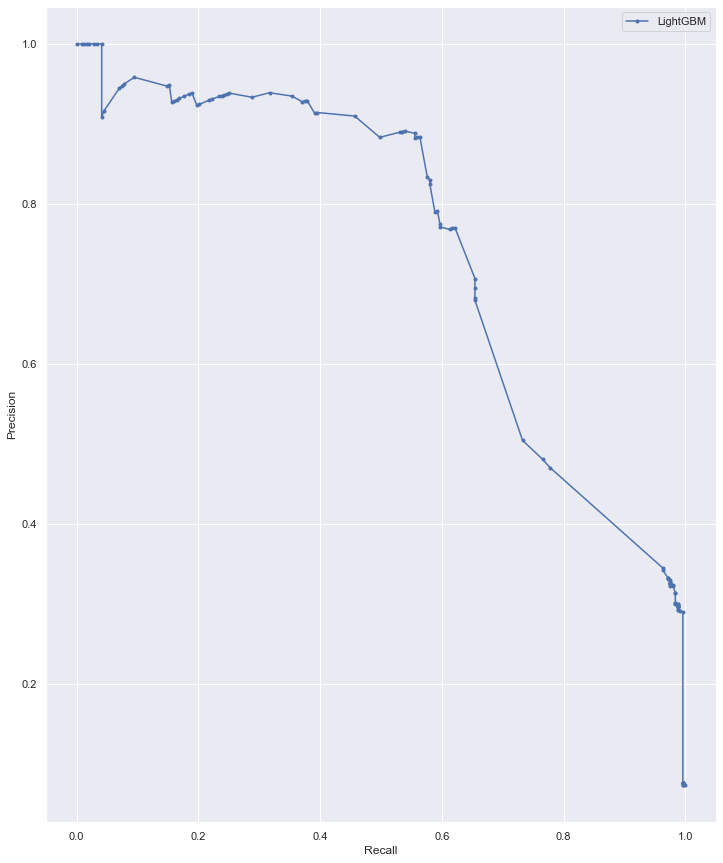

In [56]:
#Testing data

y_pred_prob=lgb_model.predict_proba(X_test)[:,1]
y_pred_threshold=[ 1 if x>=cutoff else 0 for x in y_pred_prob]
print(classification_report(y_test, y_pred_threshold))

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
lr_f1, lr_auc = f1_score(y_test, y_pred_threshold), auc(lr_recall, lr_precision)
print('LightGBM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
pyplot.plot(lr_recall, lr_precision, marker='.', label='LightGBM')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [60]:
df.correct_classification_flag.mean()

0.071214891141765

In [62]:
# save the model to disk
filename = 'Tide_receipt_transaction_mapping_model.sav'
joblib.dump(lgb_model, filename)

['Tide_receipt_transaction_mapping_model.sav']

In [64]:
#Loding the model and using it for reference
loaded_model=joblib.load('Tide_receipt_transaction_mapping_model.sav')